***1CDT***

Chunk 1 Metrics: Accuracy=0.977, F1 Score=0.9769964799827151, Precision=0.977151338304694, Recall=0.977
Chunk 2 Metrics: Accuracy=0.998, F1 Score=0.998, Precision=0.998, Recall=0.998
Chunk 3 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 4 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 5 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 6 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 7 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 8 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 9 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 10 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 11 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 12 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 13 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 14 Metrics: Accuracy=1.0, 

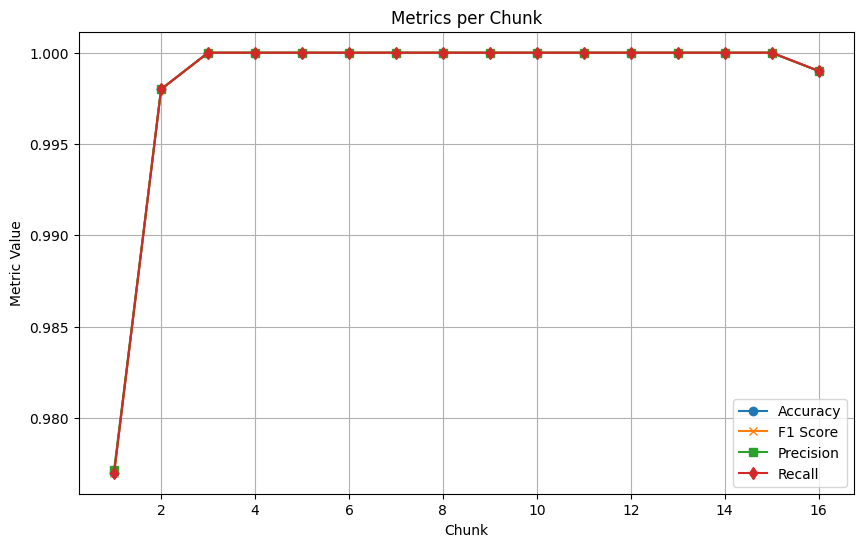

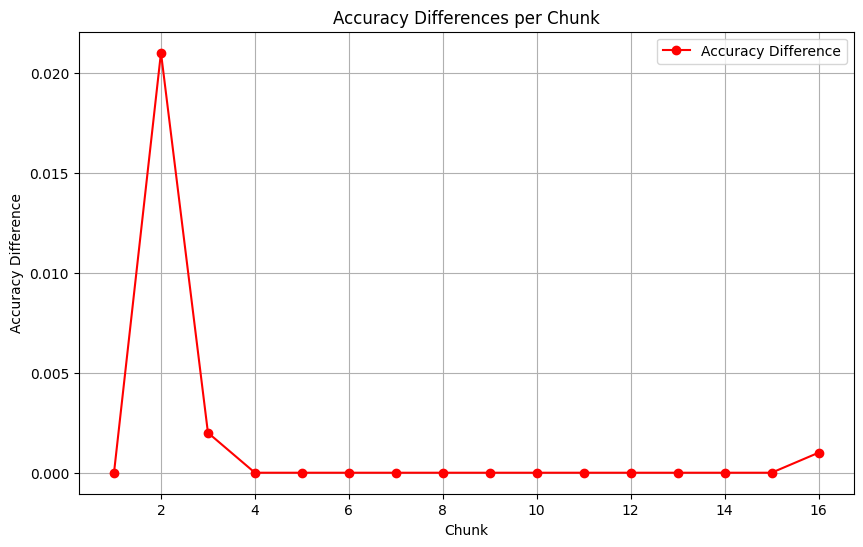

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt

file_path = './1CDT.txt'
df = pd.read_csv(file_path, delimiter=',', header=None, names=['Column1', 'Column2', 'Label'])
data = df.values

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.01 , warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=1)

chunk_size = 1000  # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Initialize unique classes on the first call
    if i == 0:
        unique_classes = np.unique(y_source)

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})

# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/1CDT_e=1_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/1CDT_e=1_summary_metrics.csv', index=False)


***2CDT***

Chunk 1 Metrics: Accuracy=0.948, F1 Score=0.9479868917529279, Precision=0.9483457620603498, Recall=0.948
Chunk 2 Metrics: Accuracy=0.941, F1 Score=0.9409902638219223, Precision=0.941404253275214, Recall=0.941
Chunk 3 Metrics: Accuracy=0.94, F1 Score=0.94, Precision=0.94000752003008, Recall=0.94
Chunk 4 Metrics: Accuracy=0.946, F1 Score=0.9459987039792636, Precision=0.9460655265526552, Recall=0.946
Chunk 5 Metrics: Accuracy=0.941, F1 Score=0.9409973449336234, Precision=0.9411471608435253, Recall=0.941
Chunk 6 Metrics: Accuracy=0.942, F1 Score=0.9419981438812083, Precision=0.9420264358067562, Recall=0.942
Chunk 7 Metrics: Accuracy=0.928, F1 Score=0.927988475390156, Precision=0.9280958191221919, Recall=0.928
Chunk 8 Metrics: Accuracy=0.929, F1 Score=0.9289990768439866, Precision=0.9290000120023525, Recall=0.929
Chunk 9 Metrics: Accuracy=0.933, F1 Score=0.9329989949748745, Precision=0.9330147849462366, Recall=0.933
Chunk 10 Metrics: Accuracy=0.93, F1 Score=0.93, Precision=0.930007440029760

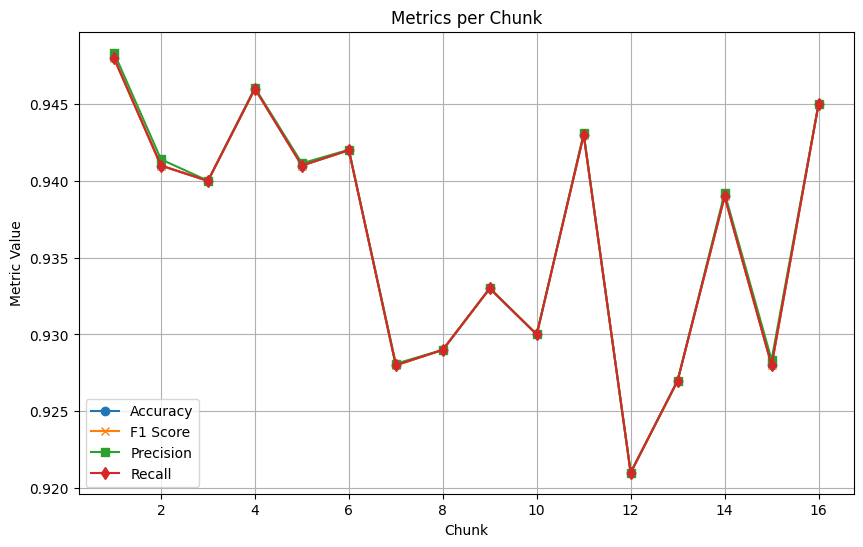

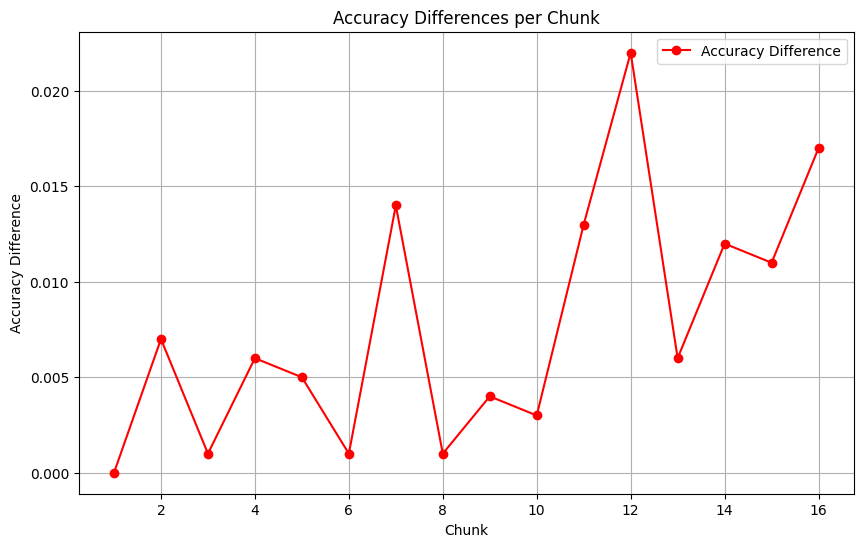

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt

# Function to upload and load the dataset
file_path = './2CDT.txt'
df = pd.read_csv(file_path, delimiter=',', header=None, names=['Column1', 'Column2', 'Label'])
data = df.values

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.01 , warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=1)

chunk_size = 1000  # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Initialize unique classes on the first call
    if i == 0:
        unique_classes = np.unique(y_source)

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})

# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/2CDT_e=1_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/2CDT_e=1_summary_metrics.csv', index=False)

***1CHT***

Chunk 1 Metrics: Accuracy=0.934, F1 Score=0.934, Precision=0.9341195596518178, Recall=0.934
Chunk 2 Metrics: Accuracy=0.986, F1 Score=0.9859993279032181, Precision=0.9860302157352282, Recall=0.986
Chunk 3 Metrics: Accuracy=0.999, F1 Score=0.9990000030000269, Precision=0.999002004008016, Recall=0.999
Chunk 4 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 5 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 6 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 7 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 8 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 9 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 10 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 11 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 12 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 13 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1

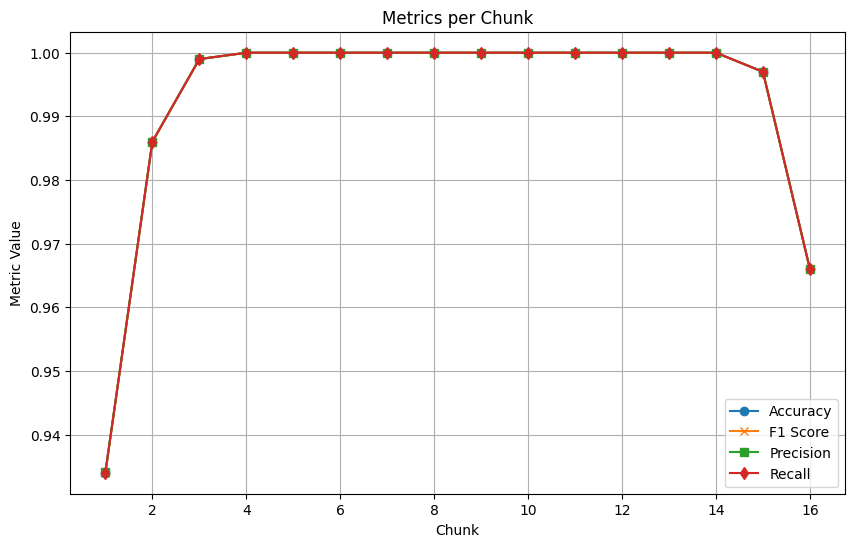

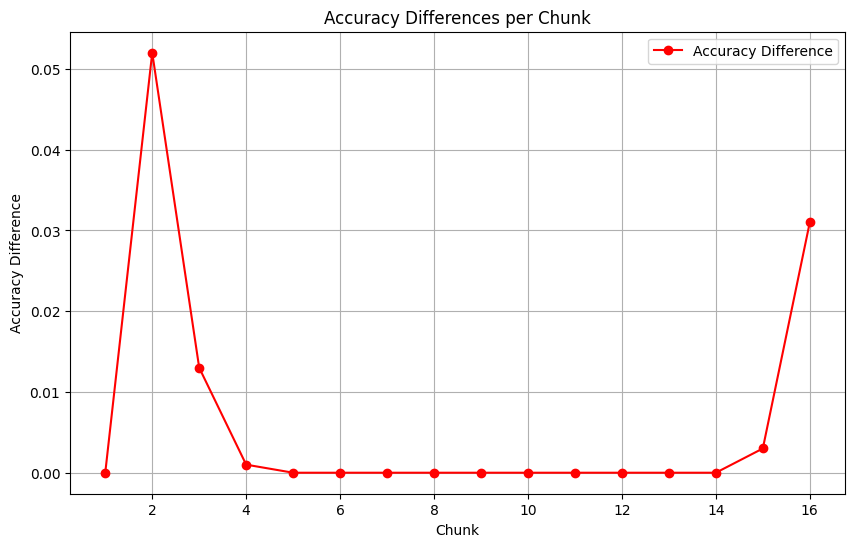

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt

file_path = './1CHT.txt'
df = pd.read_csv(file_path, delimiter=',', header=None, names=['Column1', 'Column2', 'Label'])
data = df.values

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.01 , warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=1)

chunk_size = 1000  # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Initialize unique classes on the first call
    if i == 0:
        unique_classes = np.unique(y_source)

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})

# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/1CHT_e=1_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/1CHT_e=1_summary_metrics.csv', index=False)

***2CHT***

Chunk 1 Metrics: Accuracy=0.87, F1 Score=0.8699843977532764, Precision=0.8701428691486681, Recall=0.87
Chunk 2 Metrics: Accuracy=0.873, F1 Score=0.872987425478483, Precision=0.8731163265306122, Recall=0.873
Chunk 3 Metrics: Accuracy=0.889, F1 Score=0.8890043297317247, Precision=0.8890246624662466, Recall=0.889
Chunk 4 Metrics: Accuracy=0.884, F1 Score=0.884006960250569, Precision=0.8841907230515689, Recall=0.884
Chunk 5 Metrics: Accuracy=0.896, F1 Score=0.8959883497165445, Precision=0.8960914362551475, Recall=0.896
Chunk 6 Metrics: Accuracy=0.874, F1 Score=0.874, Precision=0.874, Recall=0.874
Chunk 7 Metrics: Accuracy=0.889, F1 Score=0.8889694559099437, Precision=0.8891542879571925, Recall=0.889
Chunk 8 Metrics: Accuracy=0.883, F1 Score=0.8829490621612777, Precision=0.8832961333140961, Recall=0.883
Chunk 9 Metrics: Accuracy=0.869, F1 Score=0.8690019650176851, Precision=0.8690473801895207, Recall=0.869
Chunk 10 Metrics: Accuracy=0.88, F1 Score=0.88, Precision=0.88, Recall=0.88
Chunk 11 

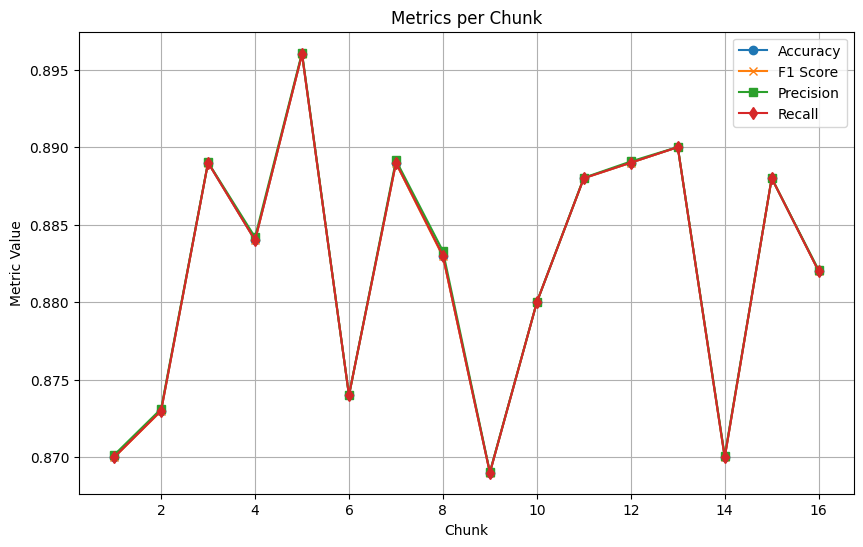

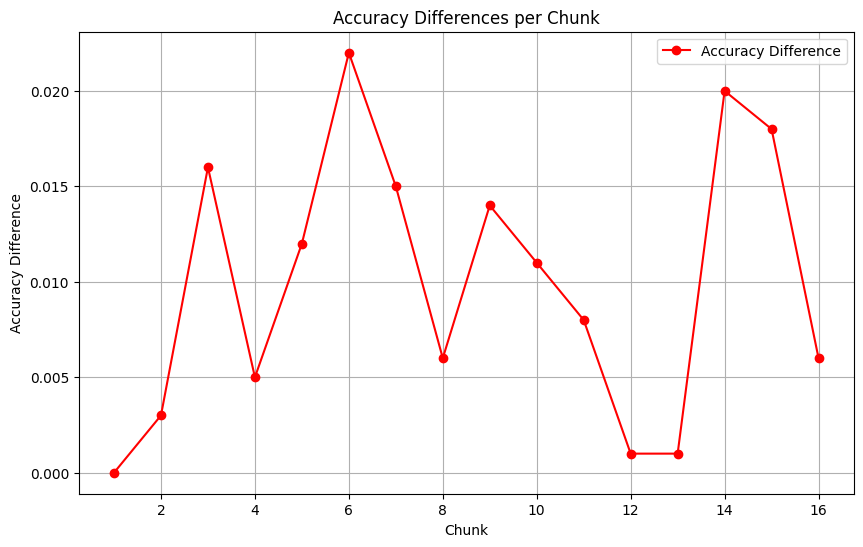

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt

file_path = './2CHT.txt'
df = pd.read_csv(file_path, delimiter=',', header=None, names=['Column1', 'Column2', 'Label'])
data = df.values

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.01 , warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=1)

chunk_size = 1000  # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Initialize unique classes on the first call
    if i == 0:
        unique_classes = np.unique(y_source)

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})
# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/2CHT_e=1_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/2CHT_e=1_summary_metrics.csv', index=False)

 ***4CR***

Chunk 1 Metrics: Accuracy=0.9999, F1 Score=0.999899999996, Precision=0.9999000399840065, Recall=0.9999
Chunk 2 Metrics: Accuracy=0.9996, F1 Score=0.9996000199600008, Precision=0.9996002398401151, Recall=0.9996
Chunk 3 Metrics: Accuracy=0.9991, F1 Score=0.9991000199560103, Precision=0.9991001597761408, Recall=0.9991
Chunk 4 Metrics: Accuracy=0.9996, F1 Score=0.9996000199600008, Precision=0.9996002398401151, Recall=0.9996
Chunk 5 Metrics: Accuracy=0.9999, F1 Score=0.999899999996, Precision=0.9999000399840065, Recall=0.9999
Chunk 6 Metrics: Accuracy=0.9997, F1 Score=0.999699999996, Precision=0.9997000399840065, Recall=0.9997
Chunk 7 Metrics: Accuracy=0.9997, F1 Score=0.9996999599279743, Precision=0.9997001998561087, Recall=0.9997
Chunk 8 Metrics: Accuracy=0.9996, F1 Score=0.9996000199120201, Precision=0.9996003995525241, Recall=0.9996
Chunk 9 Metrics: Accuracy=0.9995, F1 Score=0.9994999599599887, Precision=0.9995000398879678, Recall=0.9995
Chunk 10 Metrics: Accuracy=0.9996, F1 Score=0.999

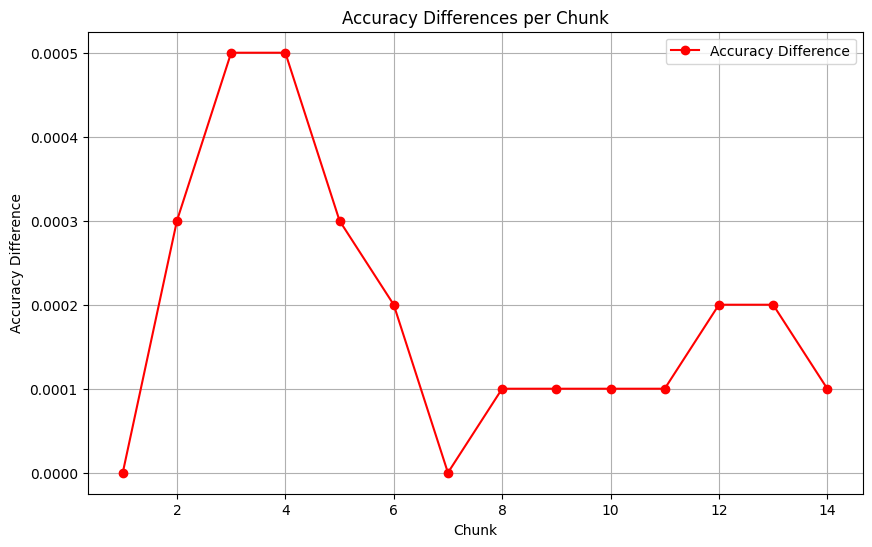

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt

file_path = './4CR.txt'
df = pd.read_csv(file_path, delimiter=',', header=None, names=['Column1', 'Column2', 'Label'])
data = df.values

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.1, warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=1)

chunk_size = 10000  # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Initialize unique classes for the 4CR dataset on the first call
    if i == 0:
        unique_classes = np.unique([1, 2, 3, 4])

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})
# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/4CR_e=1_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/4CR_e=1_summary_metrics.csv', index=False)

***4CRE-V1***

Chunk 1 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 2 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 3 Metrics: Accuracy=0.997, F1 Score=0.996999976047713, Precision=0.997011856951616, Recall=0.997
Chunk 4 Metrics: Accuracy=0.987, F1 Score=0.9870189905394002, Precision=0.9871590308805264, Recall=0.987
Chunk 5 Metrics: Accuracy=0.993, F1 Score=0.9930017805733793, Precision=0.9930628957373452, Recall=0.993
Chunk 6 Metrics: Accuracy=0.993, F1 Score=0.992997955895438, Precision=0.993007871738851, Recall=0.993
Chunk 7 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 8 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 9 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 10 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 11 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 12 Metrics: Accuracy=0.999, F1 Score=0.998999995999984, Precision=0.99900398406

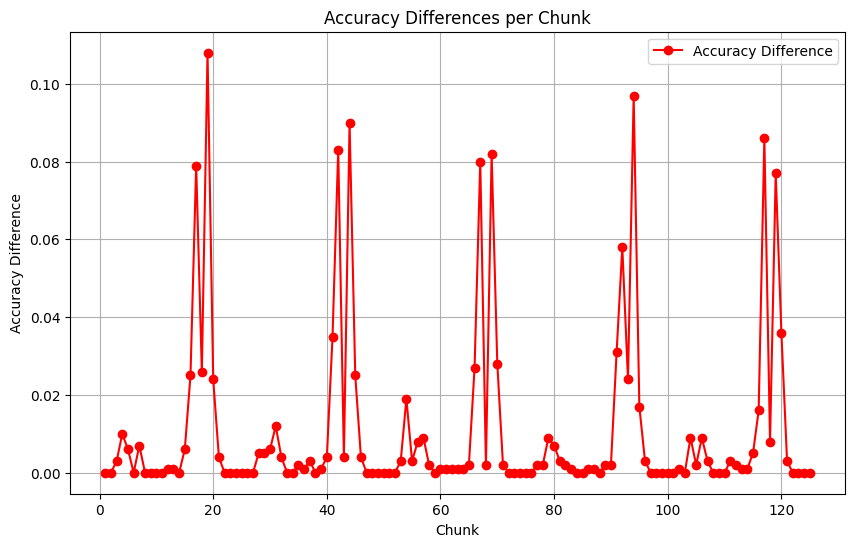

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt

file_path = './4CRE-V1.txt'
df = pd.read_csv(file_path, delimiter=',', header=None, names=['Column1', 'Column2', 'Label'])
data = df.values

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.1, warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=1)

chunk_size = 1000  # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Initialize unique classes for the 4CR dataset on the first call
    if i == 0:
        unique_classes = np.unique([1, 2, 3, 4])

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})

# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/4CREV1_e=1_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/4CREV1_e=1_summary_metrics.csv', index=False)

***4CRE-V2***

Chunk 1 Metrics: Accuracy=0.9488333333333333, F1 Score=0.9487754418545211, Precision=0.9488490479109463, Recall=0.9488333333333333
Chunk 2 Metrics: Accuracy=0.841, F1 Score=0.8410296172559519, Precision=0.841272328596634, Recall=0.841
Chunk 3 Metrics: Accuracy=0.9353333333333333, F1 Score=0.9353231697570695, Precision=0.9353226845457869, Recall=0.9353333333333333
Chunk 4 Metrics: Accuracy=0.9495, F1 Score=0.9494817183831425, Precision=0.9495254477588018, Recall=0.9495
Chunk 5 Metrics: Accuracy=0.9546666666666667, F1 Score=0.9546714932253064, Precision=0.9547251852523693, Recall=0.9546666666666667
Chunk 6 Metrics: Accuracy=0.9528333333333333, F1 Score=0.9528193691844649, Precision=0.9528265130573949, Recall=0.9528333333333333
Chunk 7 Metrics: Accuracy=0.7503333333333333, F1 Score=0.7501760368162987, Precision=0.7510149842715707, Recall=0.7503333333333333
Chunk 8 Metrics: Accuracy=0.7986666666666666, F1 Score=0.7986697905253336, Precision=0.7994127469044967, Recall=0.7986666666666666
Chu

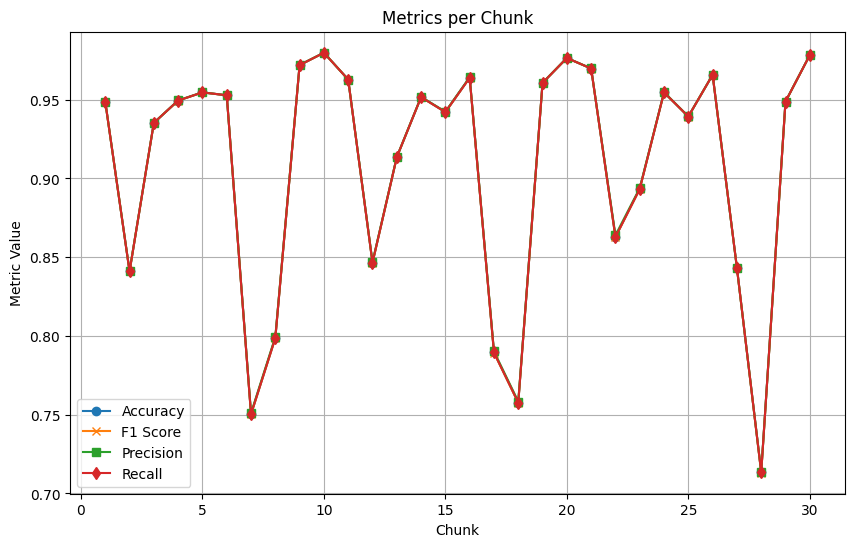

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt

file_path = './4CRE-V2.txt'
df = pd.read_csv(file_path, delimiter=',', header=None, names=['Column1', 'Column2', 'Label'])
data = df.values

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.01, warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=1)

chunk_size = 6000  # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Initialize unique classes for the 4CR dataset on the first call
    if i == 0:
        unique_classes = np.unique([1, 2, 3, 4])

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})


# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/4CREV2_e=1_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/4CREV2_e=1_summary_metrics.csv', index=False)

***5CVT***

Chunk 1 Metrics: Accuracy=0.872, F1 Score=0.86829688846055, Precision=0.8858676439649426, Recall=0.872
Chunk 2 Metrics: Accuracy=0.902, F1 Score=0.9028518685734788, Precision=0.9072495089154756, Recall=0.902
Chunk 3 Metrics: Accuracy=0.87, F1 Score=0.8692546861815377, Precision=0.8713467454849602, Recall=0.87
Chunk 4 Metrics: Accuracy=0.86, F1 Score=0.8611882589955583, Precision=0.8876773223803156, Recall=0.86
Chunk 5 Metrics: Accuracy=0.914, F1 Score=0.913353168065314, Precision=0.9141941947028869, Recall=0.914
Chunk 6 Metrics: Accuracy=0.912, F1 Score=0.9122676393186796, Precision=0.9127793163034007, Recall=0.912
Chunk 7 Metrics: Accuracy=0.906, F1 Score=0.9044842766700593, Precision=0.9064014234014235, Recall=0.906
Chunk 8 Metrics: Accuracy=0.91, F1 Score=0.9103428991010377, Precision=0.9122107155142759, Recall=0.91
Chunk 9 Metrics: Accuracy=0.87, F1 Score=0.8679562445715062, Precision=0.8698266999974318, Recall=0.87
Chunk 10 Metrics: Accuracy=0.916, F1 Score=0.9170599955079204, Pre

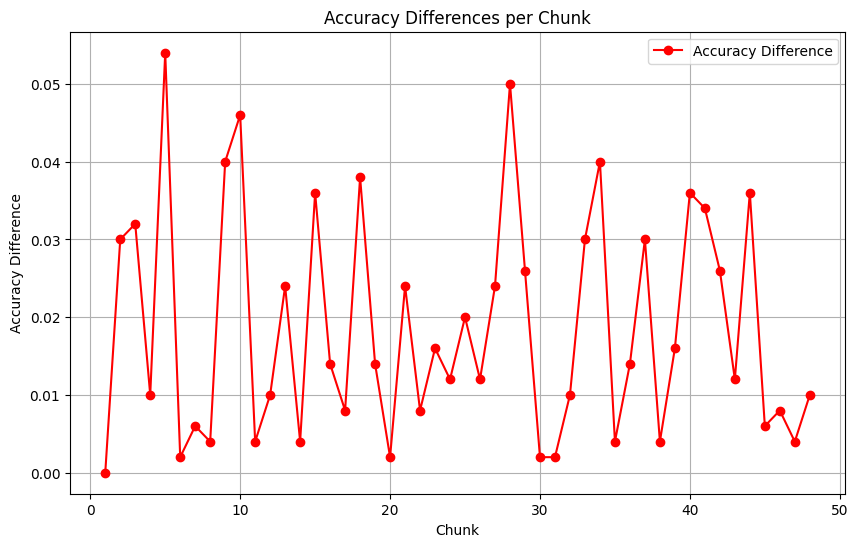

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt

file_path = './5CVT.txt'
df = pd.read_csv(file_path, delimiter=',', header=None, names=['Column1', 'Column2', 'Label'])
data = df.values

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.1, warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=1)

chunk_size = 500  # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Initialize unique classes for the 4CR dataset on the first call
    if i == 0:
        unique_classes = np.unique([1, 2, 3, 4 , 5])

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})


# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/5CVT_e=1_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/5CVT_e=1_summary_metrics.csv', index=False)

***1CSurr***

Chunk 1 Metrics: Accuracy=0.973, F1 Score=0.9731383553026526, Precision=0.9737532477199189, Recall=0.973
Chunk 2 Metrics: Accuracy=0.957, F1 Score=0.9573995153512956, Precision=0.9602426399386295, Recall=0.957
Chunk 3 Metrics: Accuracy=0.971, F1 Score=0.9711371717191555, Precision=0.9717442557442557, Recall=0.971
Chunk 4 Metrics: Accuracy=0.946, F1 Score=0.9464993694829761, Precision=0.9501107895824721, Recall=0.946
Chunk 5 Metrics: Accuracy=0.939, F1 Score=0.9393462565345181, Precision=0.9405603693181819, Recall=0.939
Chunk 6 Metrics: Accuracy=0.933, F1 Score=0.9335136625506691, Precision=0.93663663587182, Recall=0.933
Chunk 7 Metrics: Accuracy=0.946, F1 Score=0.9463984246009907, Precision=0.9481416135584022, Recall=0.946
Chunk 8 Metrics: Accuracy=0.952, F1 Score=0.9523263858093126, Precision=0.9542007764836385, Recall=0.952
Chunk 9 Metrics: Accuracy=0.951, F1 Score=0.9513576092077808, Precision=0.9531666603437157, Recall=0.951
Chunk 10 Metrics: Accuracy=0.976, F1 Score=0.976074720563

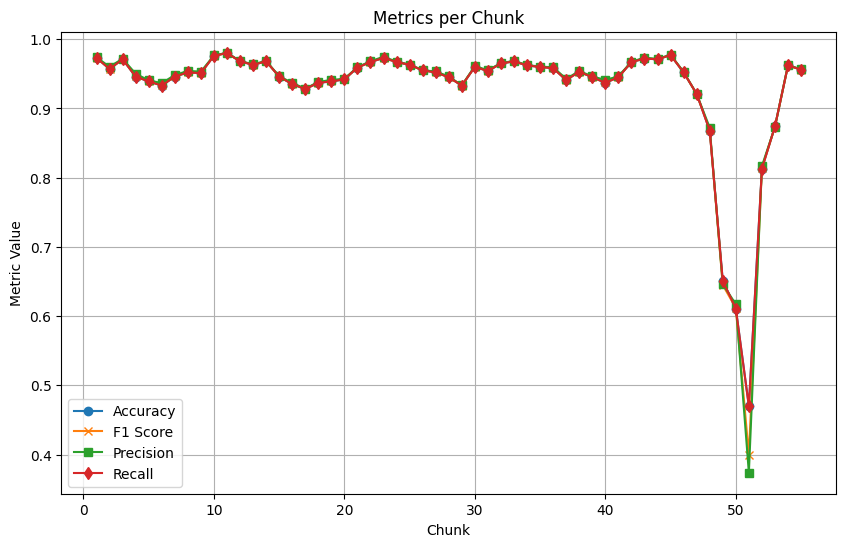

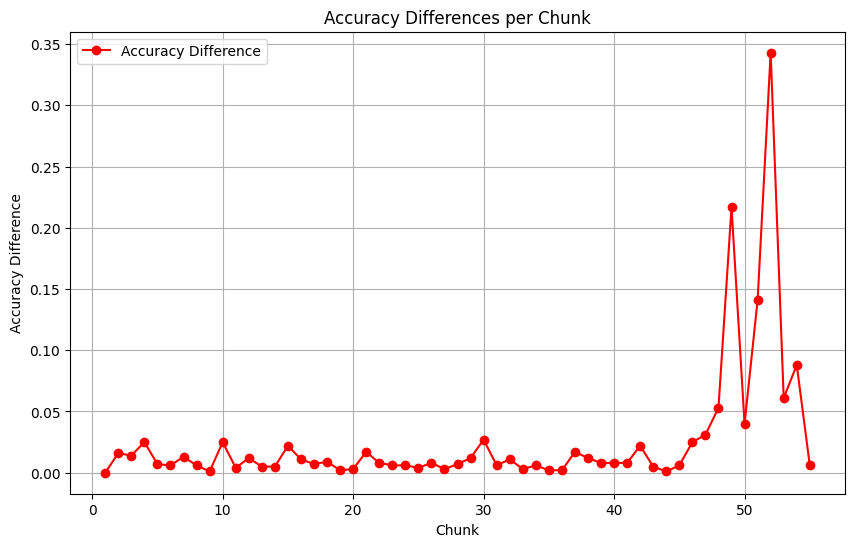

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt

file_path = './1CSurr.txt'
df = pd.read_csv(file_path, delimiter=',', header=None, names=['Column1', 'Column2', 'Label'])
data = df.values

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.05 , warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=1)

chunk_size = 1000 # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Initialize unique classes on the first call
    if i == 0:
        unique_classes = np.unique(y_source)

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})

# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/1CUsrr_e=1_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/1CUsrr_e=1_summary_metrics.csv', index=False)

***4CE1CF***

Chunk 1 Metrics: Accuracy=0.9636, F1 Score=0.9635589348510665, Precision=0.9635246961318846, Recall=0.9636
Chunk 2 Metrics: Accuracy=0.977, F1 Score=0.9769704112416275, Precision=0.9769591119490492, Recall=0.977
Chunk 3 Metrics: Accuracy=0.9769, F1 Score=0.9766864345595363, Precision=0.9768255135075631, Recall=0.9769
Chunk 4 Metrics: Accuracy=0.9808, F1 Score=0.9808237282876197, Precision=0.9808649766174605, Recall=0.9808
Chunk 5 Metrics: Accuracy=0.983, F1 Score=0.9829443243238102, Precision=0.9829376067464151, Recall=0.983
Chunk 6 Metrics: Accuracy=0.9843, F1 Score=0.9843458017535286, Precision=0.9844316513310619, Recall=0.9843
Chunk 7 Metrics: Accuracy=0.9786, F1 Score=0.978363040042409, Precision=0.9785664211926747, Recall=0.9786
Chunk 8 Metrics: Accuracy=0.9858, F1 Score=0.9857635244134959, Precision=0.9857560119175655, Recall=0.9858
Chunk 9 Metrics: Accuracy=0.9858, F1 Score=0.9857962495640497, Precision=0.9858065906607779, Recall=0.9858
Chunk 10 Metrics: Accuracy=0.9861, F1 Scor

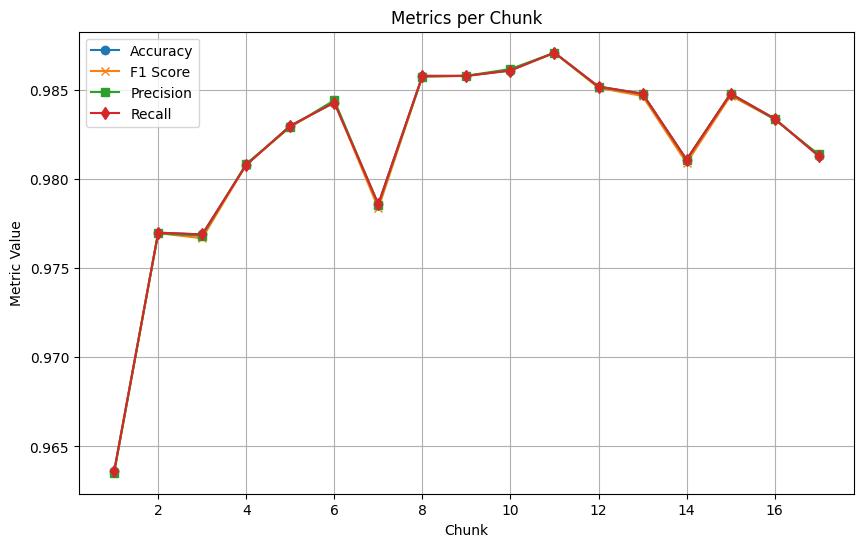

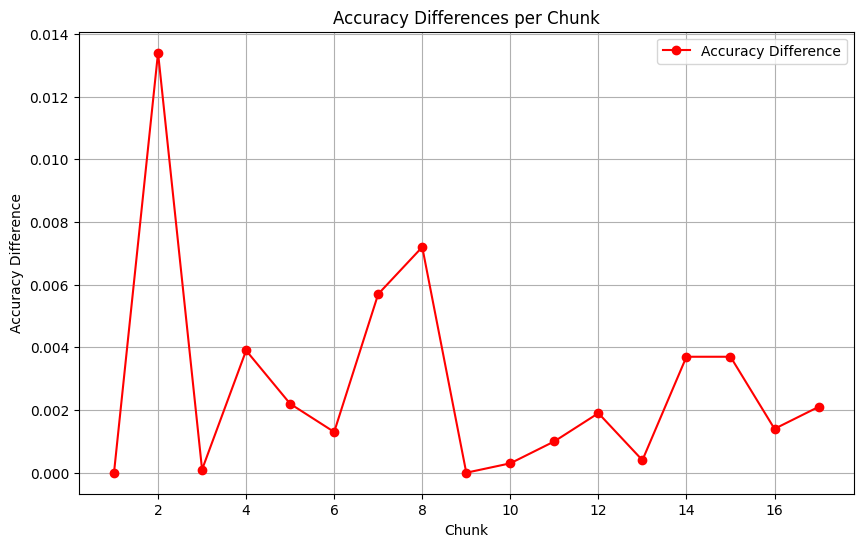

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt

file_path = './4CE1CF.txt'
df = pd.read_csv(file_path, delimiter=',', header=None, names=['Column1', 'Column2', 'Label'])
data = df.values

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.1, warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=1)

chunk_size = 10000  # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Initialize unique classes for the 4CR dataset on the first call
    if i == 0:
        unique_classes = np.unique([1, 2, 3, 4 , 5])

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})


# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/4CE1CF_e=1_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/4CE1CF_e=1_summary_metrics.csv', index=False)

***FG-2C-2D***

Chunk 1 Metrics: Accuracy=0.8979, F1 Score=0.9002466323593217, Precision=0.9057679071927596, Recall=0.8979
Chunk 2 Metrics: Accuracy=0.909, F1 Score=0.9102403579446181, Precision=0.9125272705235941, Recall=0.909
Chunk 3 Metrics: Accuracy=0.9145, F1 Score=0.9153697794028444, Precision=0.9168123468597776, Recall=0.9145
Chunk 4 Metrics: Accuracy=0.9145, F1 Score=0.9128088130036769, Precision=0.9129132516305258, Recall=0.9145
Chunk 5 Metrics: Accuracy=0.9289, F1 Score=0.9291924165635508, Precision=0.9295768025349731, Recall=0.9289
Chunk 6 Metrics: Accuracy=0.9343, F1 Score=0.9348251690920272, Precision=0.9357110573042777, Recall=0.9343
Chunk 7 Metrics: Accuracy=0.9448, F1 Score=0.9442277797237087, Precision=0.9442062128198558, Recall=0.9448
Chunk 8 Metrics: Accuracy=0.916, F1 Score=0.9148026315789474, Precision=0.9145680406549971, Recall=0.916
Chunk 9 Metrics: Accuracy=0.8403, F1 Score=0.8336323644509217, Precision=0.8329930202295043, Recall=0.8403
Chunk 10 Metrics: Accuracy=0.7426, F1 Sco

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Chunk 16 Metrics: Accuracy=0.7315, F1 Score=0.6663585508759874, Precision=0.6562321069007848, Recall=0.7315
Chunk 17 Metrics: Accuracy=0.7703, F1 Score=0.7147814020207591, Precision=0.7482218998559914, Recall=0.7703
Chunk 18 Metrics: Accuracy=0.8648, F1 Score=0.8617005482989085, Precision=0.8607235776635738, Recall=0.8648
Chunk 19 Metrics: Accuracy=0.9124, F1 Score=0.9130625555660765, Precision=0.9140342819721915, Recall=0.9124
Chunk 20 Metrics: Accuracy=0.9534, F1 Score=0.9529849933007357, Precision=0.9529864013915184, Recall=0.9534
Final Average Accuracy: 0.841905
Total time for processing: 0.6226963996887207 seconds
Normalized Total Absolute Accuracy Differences (N-TAAD): 0.03248947368421052
    Chunk  Accuracy  F1 Score  Precision  Recall  Accuracy Difference
0       1    0.8979  0.900247   0.905768  0.8979               0.0000
1       2    0.9090  0.910240   0.912527  0.9090               0.0111
2       3    0.9145  0.915370   0.916812  0.9145               0.0055
3       4    0.9

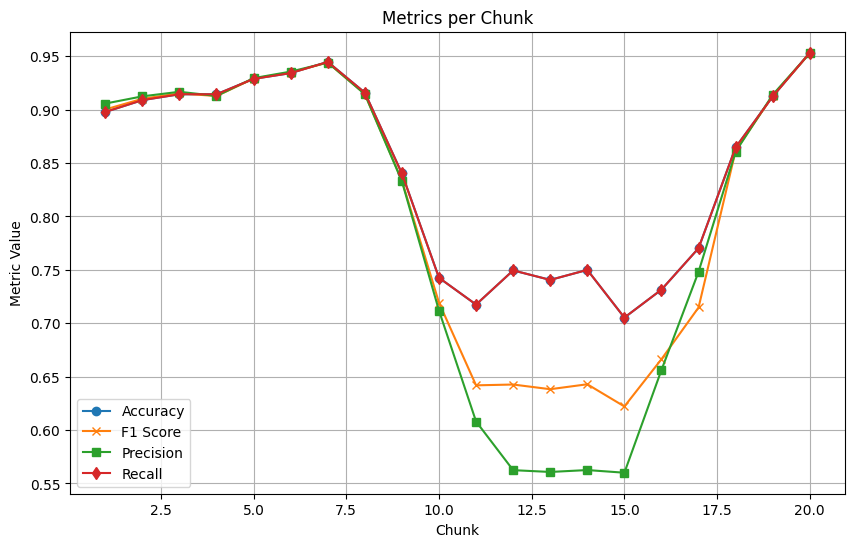

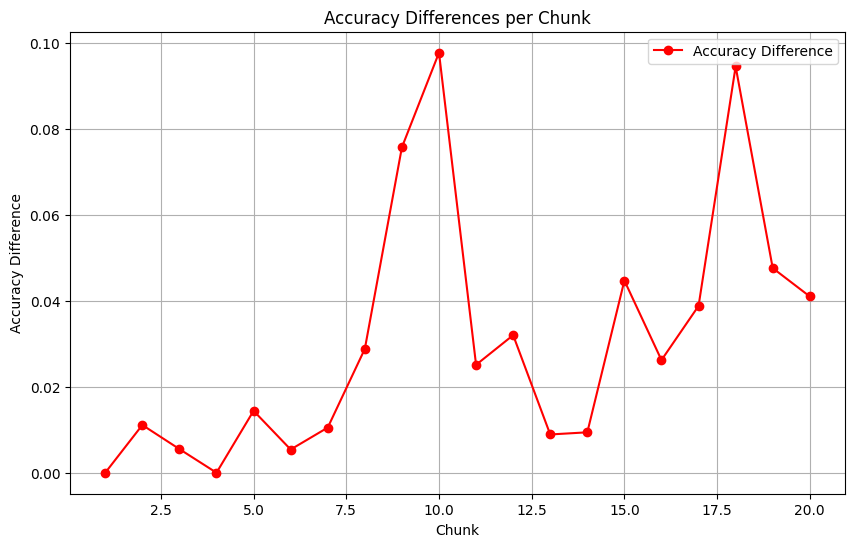

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt

file_path = './FG_2C_2D.txt'
df = pd.read_csv(file_path, delimiter=',', header=None, names=['Column1', 'Column2', 'Label'])
data = df.values


# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.1 , warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=1)

chunk_size = 10000 # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Initialize unique classes on the first call
    if i == 0:
        unique_classes = np.unique(y_source)

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})

# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/FG2C2D_e=1_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/FG2C2D_e=1_summary_metrics.csv', index=False)

***UG-2C-2D***

Chunk 1 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 2 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 3 Metrics: Accuracy=0.998, F1 Score=0.998, Precision=0.998, Recall=0.998
Chunk 4 Metrics: Accuracy=0.997, F1 Score=0.996999996999997, Precision=0.997001988007952, Recall=0.997
Chunk 5 Metrics: Accuracy=0.995, F1 Score=0.9949999949999949, Precision=0.99500198000792, Recall=0.995
Chunk 6 Metrics: Accuracy=0.989, F1 Score=0.9889999009991091, Precision=0.9890176046337669, Recall=0.989
Chunk 7 Metrics: Accuracy=0.995, F1 Score=0.9949998749968749, Precision=0.995049504950495, Recall=0.995
Chunk 8 Metrics: Accuracy=0.987, F1 Score=0.9869999869999869, Precision=0.987001948007792, Recall=0.987
Chunk 9 Metrics: Accuracy=0.986, F1 Score=0.985999775996416, Precision=0.9860311059907834, Recall=0.986
Chunk 10 Metrics: Accuracy=0.972, F1 Score=0.972, Precision=0.972, Recall=0.972
Chunk 11 Metrics: Accuracy=0.98, F1 Score=0.9799999199996801, Precision=0.98

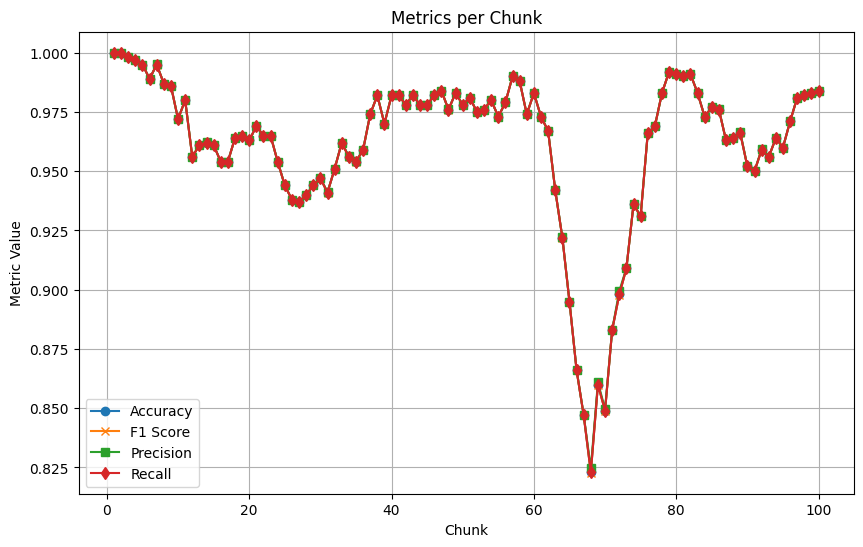

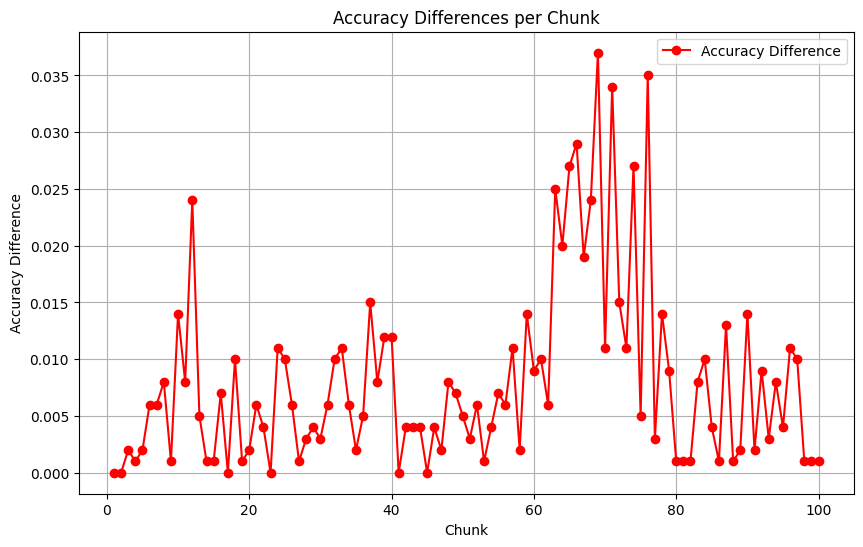

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt

file_path = './UG_2C_2D.txt'
df = pd.read_csv(file_path, delimiter=',', header=None, names=['Column1', 'Column2', 'Label'])
data = df.values

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.05, warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=1)

chunk_size = 1000 # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Initialize unique classes on the first call
    if i == 0:
        unique_classes = np.unique(y_source)

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})
# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/UG2C2D_e=1_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/UG2C2D_e=1_summary_metrics.csv', index=False)

***UG-2C-3D***

Chunk 1 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 2 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 3 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 4 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 5 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 6 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 7 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 8 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 9 Metrics: Accuracy=0.999, F1 Score=0.998999998999999, Precision=0.999001996007984, Recall=0.999
Chunk 10 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 11 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 12 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 13 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 14 Metrics: Accuracy=1.0, F1 Score=

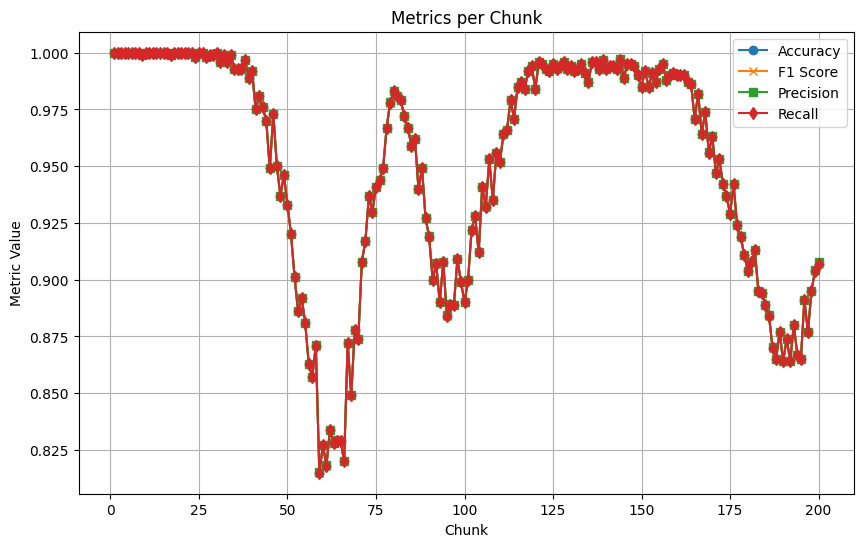

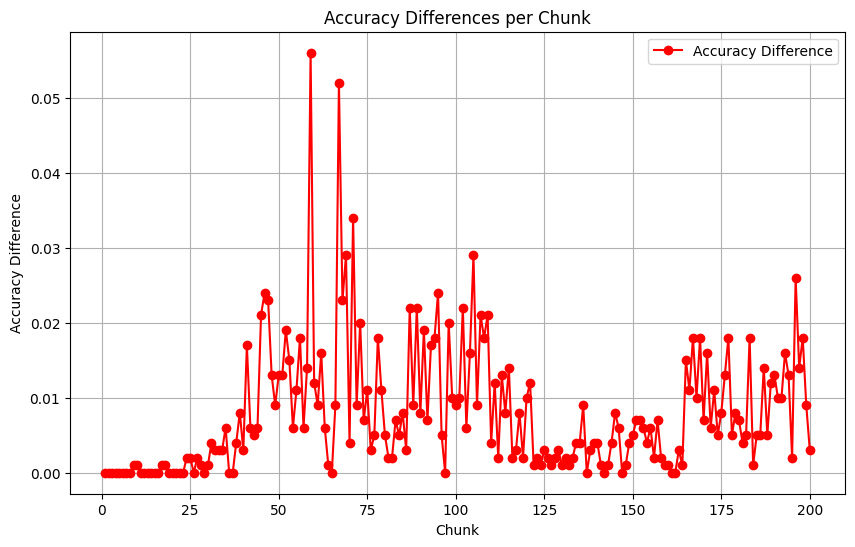

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt

file_path = './UG_2C_3D.txt'
df = pd.read_csv(file_path, delimiter=',', header=None, names=['Column1', 'Column2','Column3', 'Label'])
data = df.values

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.01 , warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=1)

chunk_size = 1000 # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Initialize unique classes on the first call
    if i == 0:
        unique_classes = np.unique(y_source)

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})

# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/UG2C3D_e=1_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/UG2C3D_e=1_summary_metrics.csv', index=False)

***UG-2C-5D***

Chunk 1 Metrics: Accuracy=0.999, F1 Score=0.9989999829950856, Precision=0.9990019646365422, Recall=0.999
Chunk 2 Metrics: Accuracy=0.998, F1 Score=0.998, Precision=0.998, Recall=0.998
Chunk 3 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 4 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 5 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 6 Metrics: Accuracy=0.999, F1 Score=0.9990000170049144, Precision=0.9990020325203252, Recall=0.999
Chunk 7 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 8 Metrics: Accuracy=0.998, F1 Score=0.998, Precision=0.998, Recall=0.998
Chunk 9 Metrics: Accuracy=0.997, F1 Score=0.9970001350303819, Precision=0.9970182186234817, Recall=0.997
Chunk 10 Metrics: Accuracy=0.996, F1 Score=0.996, Precision=0.996, Recall=0.996
Chunk 11 Metrics: Accuracy=0.997, F1 Score=0.9970000630277952, Precision=0.9970021208483393, Recall=0.997
Chunk 12 Metrics: Accuracy=0.997, F1 Score=0.996999930963

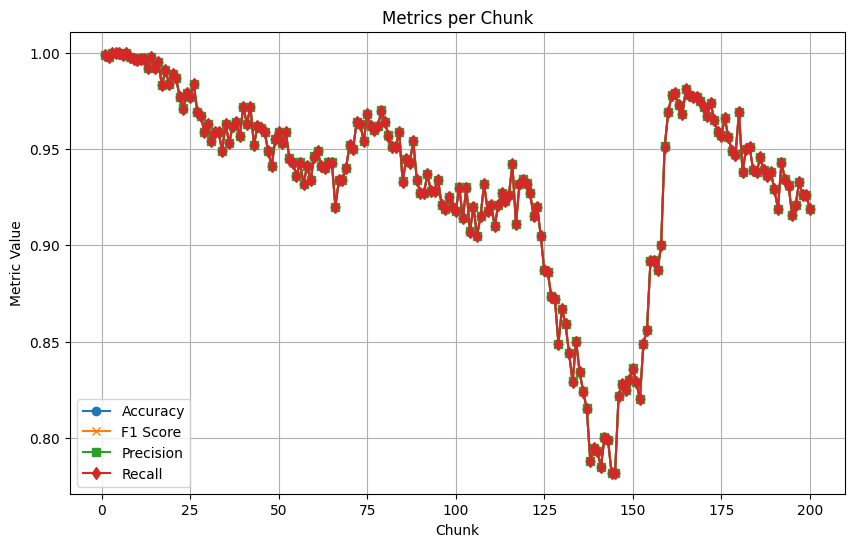

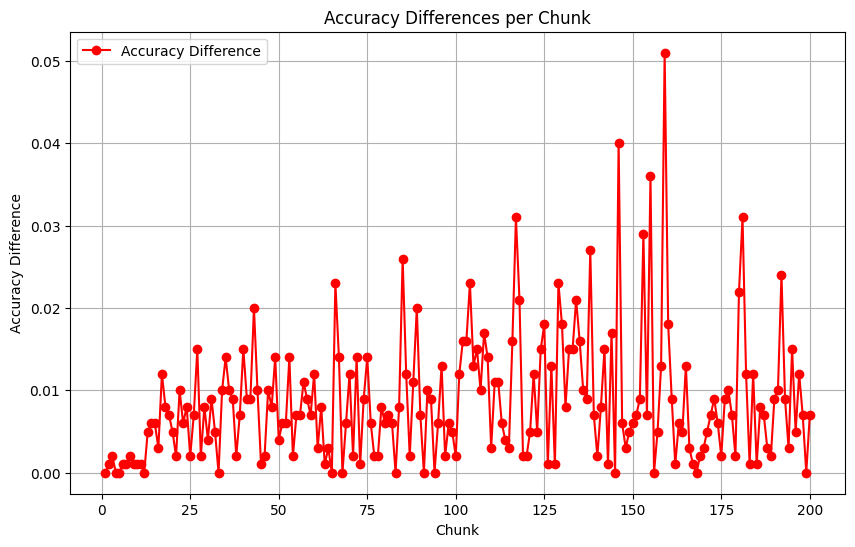

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt

file_path = './UG_2C_5D.txt'
df = pd.read_csv(file_path, delimiter=',', header=None, names=['Column1', 'Column2','Column3','Column4','Column5','Label'])
data = df.values

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.01 , warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=1)

chunk_size = 1000 # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Initialize unique classes on the first call
    if i == 0:
        unique_classes = np.unique(y_source)

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})

# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/UG2C5D_e=1_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/UG2C5D_e=1_summary_metrics.csv', index=False)

***MG_2C_2D***

Chunk 1 Metrics: Accuracy=0.9985, F1 Score=0.998499999985, Precision=0.9985000199400008, Recall=0.9985
Chunk 2 Metrics: Accuracy=0.9961, F1 Score=0.9960999968409975, Precision=0.9961016073692078, Recall=0.9961
Chunk 3 Metrics: Accuracy=0.9892, F1 Score=0.9891999723519294, Precision=0.9892050094592969, Recall=0.9892
Chunk 4 Metrics: Accuracy=0.9781, F1 Score=0.9780999945249987, Precision=0.978100478100478, Recall=0.9781
Chunk 5 Metrics: Accuracy=0.9573, F1 Score=0.9572979669562068, Precision=0.957387104800238, Recall=0.9573
Chunk 6 Metrics: Accuracy=0.9244, F1 Score=0.9243924392439243, Precision=0.9245698279311724, Recall=0.9244
Chunk 7 Metrics: Accuracy=0.8767, F1 Score=0.8766926891095372, Precision=0.8767893593644669, Recall=0.8767
Chunk 8 Metrics: Accuracy=0.7997, F1 Score=0.7996987481171757, Precision=0.7997074926873171, Recall=0.7997
Chunk 9 Metrics: Accuracy=0.6943, F1 Score=0.6929338966836167, Precision=0.6978203234349052, Recall=0.6943
Chunk 10 Metrics: Accuracy=0.5611, F1 Score

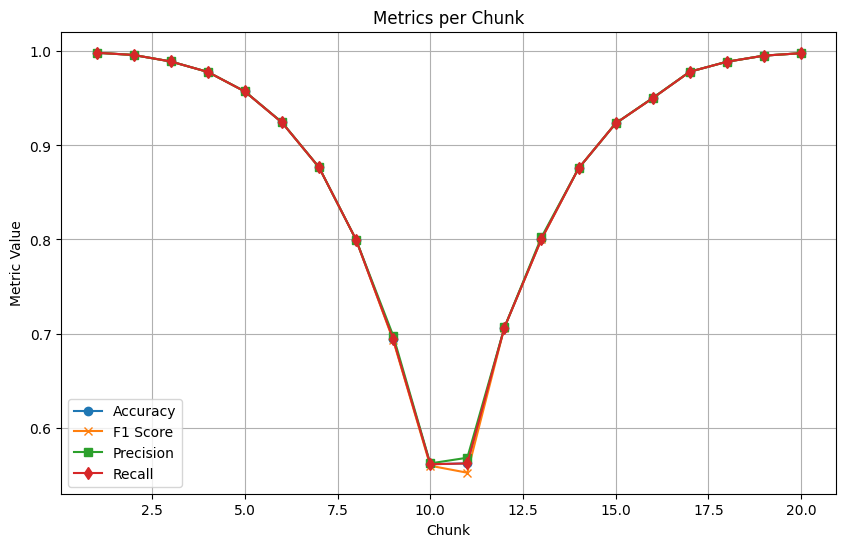

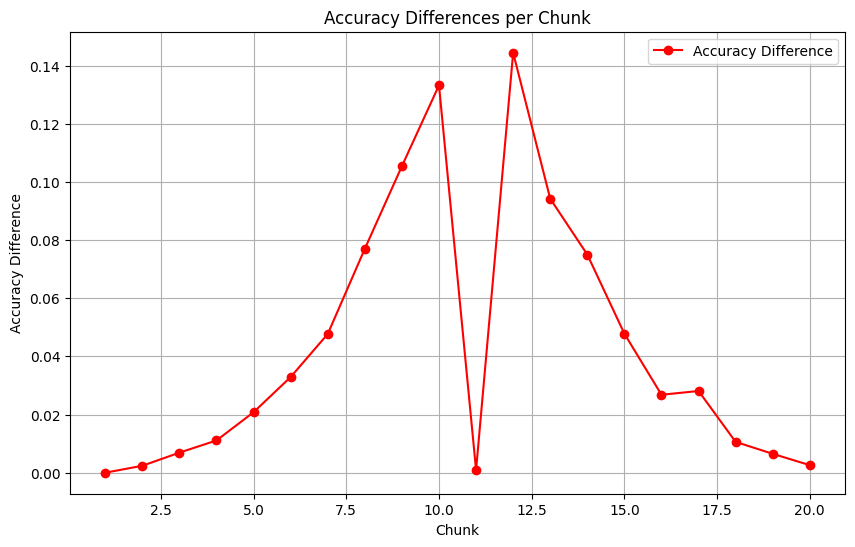

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt

file_path = './MG_2C_2D.txt'
df = pd.read_csv(file_path, delimiter=',', header=None, names=['Column1', 'Column2', 'Label'])
data = df.values

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.05, warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=1)

chunk_size = 10000 # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Initialize unique classes on the first call
    if i == 0:
        unique_classes = np.unique(y_source)

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})

# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/MG2C2D_e=1_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/MG2C2D_e=1_summary_metrics.csv', index=False)

***GEARS-2C-2D***

Chunk 1 Metrics: Accuracy=0.9582, F1 Score=0.9581997592306132, Precision=0.958210557171237, Recall=0.9582
Chunk 2 Metrics: Accuracy=0.9607, F1 Score=0.9606997921019002, Precision=0.9607097486182807, Recall=0.9607
Chunk 3 Metrics: Accuracy=0.959, F1 Score=0.9589999196398424, Precision=0.9590035985882128, Recall=0.959
Chunk 4 Metrics: Accuracy=0.9604, F1 Score=0.9603997719026862, Precision=0.9604106078604051, Recall=0.9604
Chunk 5 Metrics: Accuracy=0.9613, F1 Score=0.961299999613, Precision=0.9613000184520006, Recall=0.9613
Chunk 6 Metrics: Accuracy=0.9562, F1 Score=0.9561998247992991, Precision=0.956207299316789, Recall=0.9562
Chunk 7 Metrics: Accuracy=0.9611, F1 Score=0.9610993460800077, Precision=0.9611310064488736, Recall=0.9611
Chunk 8 Metrics: Accuracy=0.9631, F1 Score=0.9630999376388947, Precision=0.9631031305771627, Recall=0.9631
Chunk 9 Metrics: Accuracy=0.9586, F1 Score=0.9585999933759991, Precision=0.9586002935041877, Recall=0.9586
Chunk 10 Metrics: Accuracy=0.9586, F1 Score=0

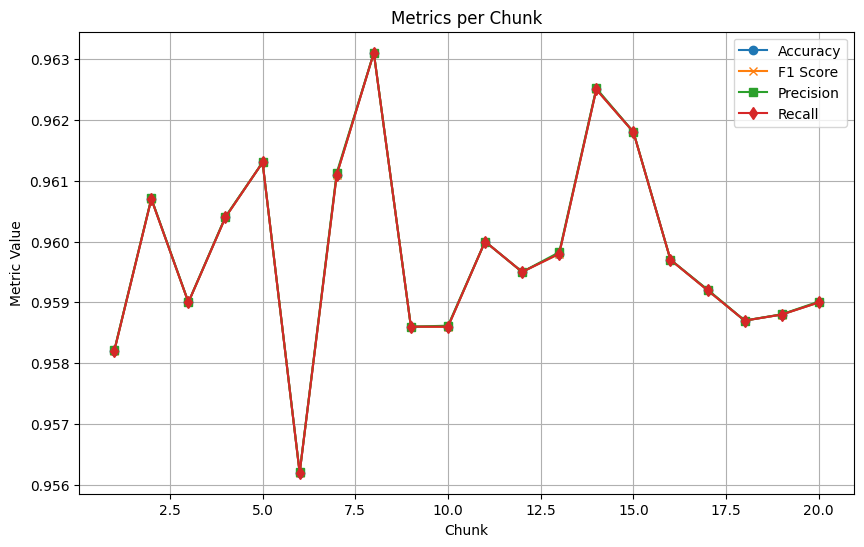

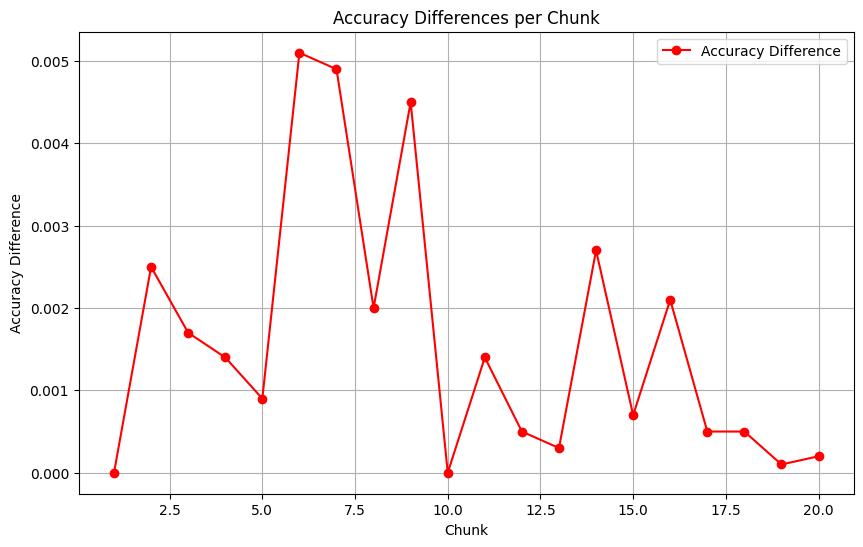

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt

file_path = './GEARS_2C_2D.txt'
df = pd.read_csv(file_path, delimiter=',', header=None, names=['Column1', 'Column2', 'Label'])
data = df.values

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.01, warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=1)

chunk_size = 10000 # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Initialize unique classes on the first call
    if i == 0:
        unique_classes = np.unique(y_source)

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})

# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/GEAR2C2D_e=1_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/GEAR2C2D_e=1_summary_metrics.csv', index=False)

**`Real-world Datasets`**

***Keystroke***

Chunk 1 Metrics: Accuracy=0.81, F1 Score=0.7904641263654547, Precision=0.8204313929313929, Recall=0.81
Chunk 2 Metrics: Accuracy=0.97, F1 Score=0.9699639471173086, Precision=0.971866096866097, Recall=0.97
Chunk 3 Metrics: Accuracy=0.91, F1 Score=0.9081140138687309, Precision=0.9136772486772488, Recall=0.91
Chunk 4 Metrics: Accuracy=0.99, F1 Score=0.9899959983993597, Precision=0.9903846153846154, Recall=0.99
Chunk 5 Metrics: Accuracy=0.96, F1 Score=0.9601920768307324, Precision=0.9607692307692308, Recall=0.96
Chunk 6 Metrics: Accuracy=0.94, F1 Score=0.940171568627451, Precision=0.9415384615384617, Recall=0.94
Chunk 7 Metrics: Accuracy=0.98, F1 Score=0.9801805337519623, Precision=0.9814814814814815, Recall=0.98
Chunk 8 Metrics: Accuracy=0.98, F1 Score=0.9801805337519625, Precision=0.9814814814814815, Recall=0.98
Chunk 9 Metrics: Accuracy=0.98, F1 Score=0.9799959983993597, Precision=0.9803846153846155, Recall=0.98
Chunk 10 Metrics: Accuracy=0.95, F1 Score=0.9497549019607843, Precision=0.9

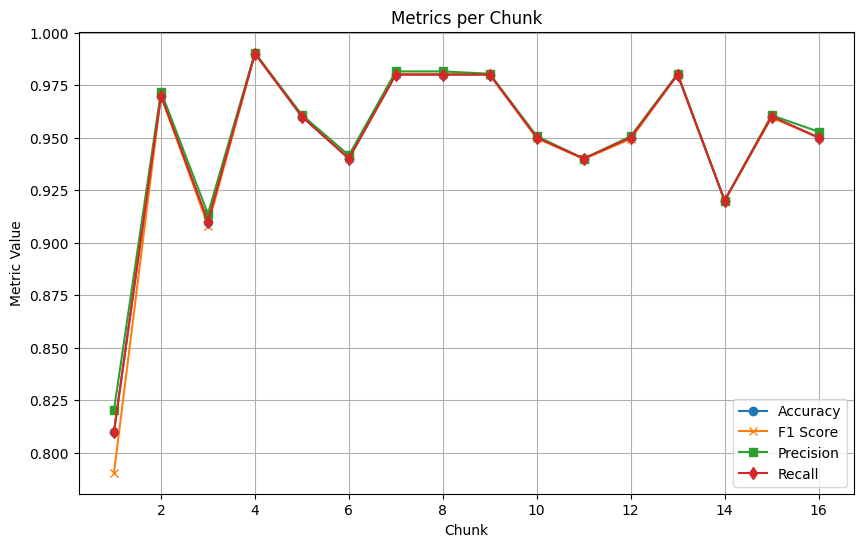

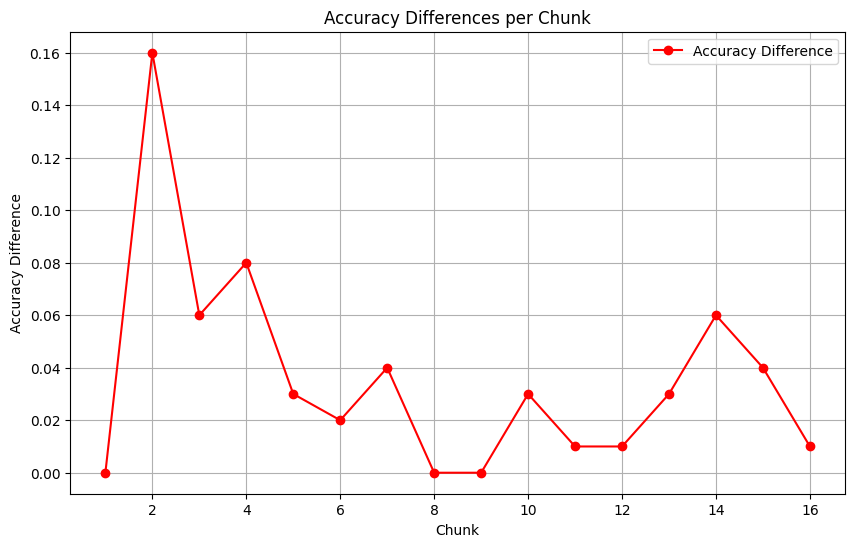

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt

file_path = './keystroke.txt'
df = pd.read_csv(file_path, delimiter=',', header=None, names=['Column1', 'Column2','Column3','Column4', 'Column5','Column6','Column7','Column8','Column9','Column10','Label'])
data = df.values

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.1, warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=1)

chunk_size = 100  # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Initialize unique classes for the 4CR dataset on the first call
    if i == 0:
        unique_classes = np.unique([1, 2, 3, 4])

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})

# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/Keystroke_e=1_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/Keystroke_e=1_summary_metrics.csv', index=False)

**Energy Efficiency**
 https://archive.ics.uci.edu/dataset/242/energy+efficiency

In [ ]:
''' The dataset contains eight attributes (or features, denoted by X1...X8) and two responses (or outcomes, denoted by y1 and y2). The aim is to use the eight features to predict each of the two responses.
Specifically:
X1	Relative Compactness
X2	Surface Area
X3	Wall Area
X4	Roof Area
X5	Overall Height
X6	Orientation
X7	Glazing Area
X8	Glazing Area Distribution
y1	Heating Load
y2	Cooling Load

SyntaxError: incomplete input (<ipython-input-41-f5b6825162c3>, line 1)

 Prediction for Y1: Heating Load

     X1     X2     X3      X4   X5  X6   X7  X8     Y1  Y1_binned
0  0.98  514.5  294.0  110.25  7.0   2  0.0   0  15.55        0.0
1  0.98  514.5  294.0  110.25  7.0   3  0.0   0  15.55        0.0
2  0.98  514.5  294.0  110.25  7.0   4  0.0   0  15.55        0.0
3  0.98  514.5  294.0  110.25  7.0   5  0.0   0  15.55        0.0
4  0.90  563.5  318.5  122.50  7.0   2  0.0   0  20.84        1.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   X1         768 non-null    float64
 1   X2         768 non-null    float64
 2   X3         768 non-null    float64
 3   X4         768 non-null    float64
 4   X5         768 non-null    float64
 5   X6         768 non-null    int64  
 6   X7         768 non-null    float64
 7   X8         768 non-null    int64  
 8   Y1         768 non-null    float64
 9   Y1_binned  768 non-null    float64
dtypes: float64(8),

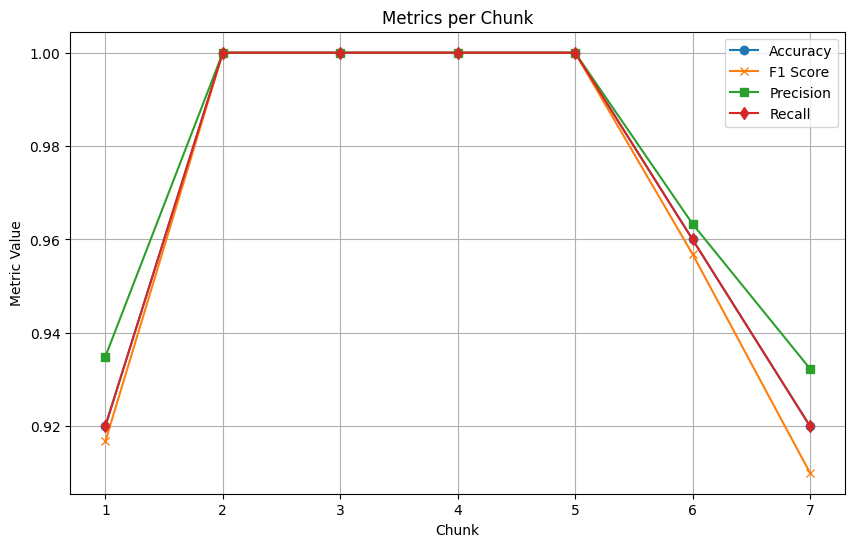

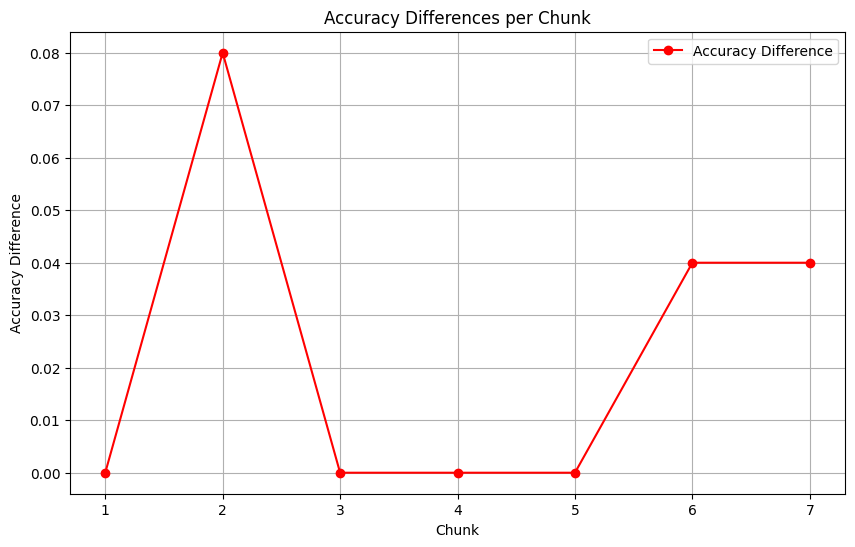

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer

from google.colab import drive


# Function to load the dataset
def load_data():
    # Provide the full path to your dataset in Google Drive
    file_path = './ENB2012_data.xlsx'
    # Load the Excel file
    df = pd.read_excel(file_path)

    # Drop the 'Y2' column
    df = df.drop(columns=['Y2'])

    return df

# Load the dataset
df = load_data()

# Convert Y1 (continuous heating load) to a categorical variable using binning (for classification purposes)
# For example, bin Y1 into 3 categories (low, medium, high)
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
df['Y1_binned'] = discretizer.fit_transform(df[['Y1']])

# Prepare data by excluding the original 'Y1' and using 'Y1_binned' as labels
data = df.drop(columns=['Y1']).values  # Features
labels = df['Y1_binned'].values  # Categorical labels (binned)

# Combine features and labels into the data array for chunk processing
data = np.hstack((data, labels.reshape(-1, 1)))

# Preview the dataset to ensure proper loading and conversion
print(df.head())
print(df.info())

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.1, warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=1)

chunk_size = 100  # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Get unique classes from the entire dataset to avoid class mismatch
unique_classes = np.unique(labels)

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call to ensure all classes are handled
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

   # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})

# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/Y1_e=1_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/Y1_e=1_summary_metrics.csv', index=False)

Prediction for Y2: Cooling Load

     X1     X2     X3      X4   X5  X6   X7  X8     Y2  Y2_binned
0  0.98  514.5  294.0  110.25  7.0   2  0.0   0  21.33        0.0
1  0.98  514.5  294.0  110.25  7.0   3  0.0   0  21.33        0.0
2  0.98  514.5  294.0  110.25  7.0   4  0.0   0  21.33        0.0
3  0.98  514.5  294.0  110.25  7.0   5  0.0   0  21.33        0.0
4  0.90  563.5  318.5  122.50  7.0   2  0.0   0  28.28        1.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   X1         768 non-null    float64
 1   X2         768 non-null    float64
 2   X3         768 non-null    float64
 3   X4         768 non-null    float64
 4   X5         768 non-null    float64
 5   X6         768 non-null    int64  
 6   X7         768 non-null    float64
 7   X8         768 non-null    int64  
 8   Y2         768 non-null    float64
 9   Y2_binned  768 non-null    float64
dtypes: float64(8),

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


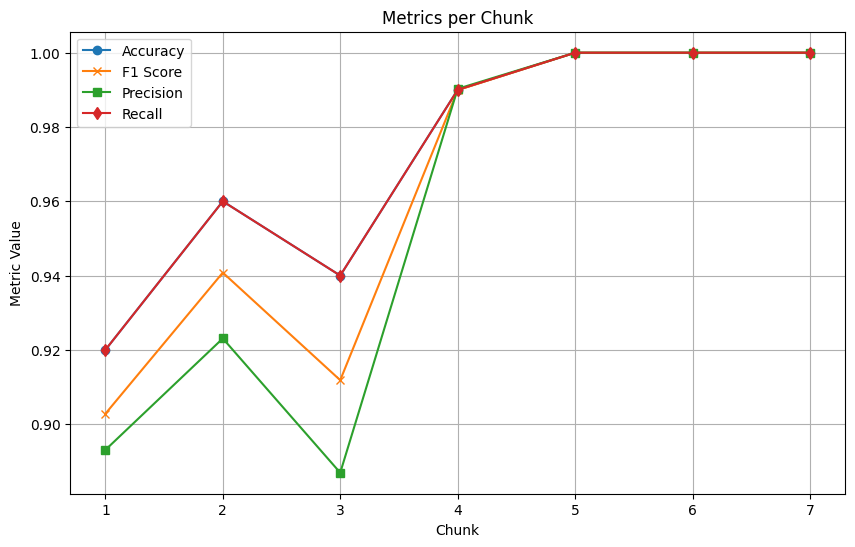

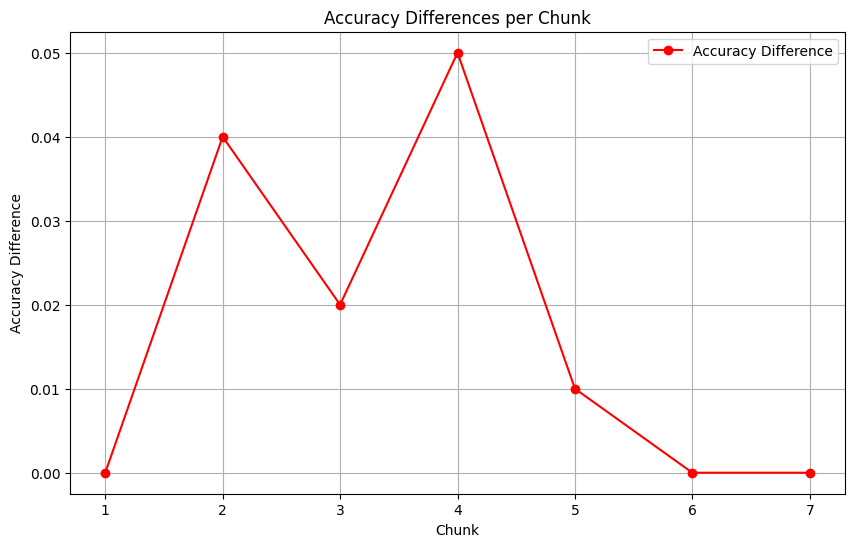

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer

# Function to load the dataset
def load_data():
    # Provide the full path to your dataset in Google Drive
    file_path = './ENB2012_data.xlsx'
    # Load the Excel file
    df = pd.read_excel(file_path)

    # Drop the 'Y1' column
    df = df.drop(columns=['Y1'])

    return df

# Load the dataset
df = load_data()

# Convert Y2 (continuous heating load) to a categorical variable using binning (for classification purposes)
# For example, bin Y2 into 3 categories (low, medium, high)
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
df['Y2_binned'] = discretizer.fit_transform(df[['Y2']])

# Prepare data by excluding the original 'Y2' and using 'Y2_binned' as labels
data = df.drop(columns=['Y2']).values  # Features
labels = df['Y2_binned'].values  # Categorical labels (binned)

# Combine features and labels into the data array for chunk processing
data = np.hstack((data, labels.reshape(-1, 1)))

# Preview the dataset to ensure proper loading and conversion
print(df.head())
print(df.info())

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.1, warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=1)

chunk_size = 100  # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Get unique classes from the entire dataset to avoid class mismatch
unique_classes = np.unique(labels)

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call to ensure all classes are handled
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})

# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/Y2_e=1_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/Y2_e=1_summary_metrics.csv', index=False)